# <center> Практические задания по цифровой обработке сигналов </center>
## <center> Первая лабораторная работа </center>

**Булаев Владимир, группа DS-22**


В данной работе Вы познакомитесь с основными методами работы с аудиоданными в Python. Разбересь в том, как работает свертка, и примените пару интересных фильтров.

# Задание 1. Работа с аудиофайлами в Python (1 балл)

## Теория

Звук - это аналоговый сигнал. То есть он является непрерывным по времени и по значениям. Для того, чтобы работать со звуком на цифровом устройстве, надо преобразовать его в цифровое представление. Для этого надо разделить непрерывный сигнал на промежутки времени (дискретизация сигнала) и разбить непрерывные значения на интервалы (квантование сигнала). Выбраные параметры дискретизации и квантования сигнала напрямую влияют на качество цифрового сигнала. 


## Практика

1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла? 

2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?   

3. Чем .wav отличается от других кодеков, например .mp3 или .ogg?


### Подсказка

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib.

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

import scipy.signal
from scipy.io import wavfile
from IPython.display import Audio

In [2]:
# Загрузка файла и проигрывание с помощью IPython.display
wav_fname = './resources/my_eng_cut.wav' 
samplerate, data = wavfile.read(wav_fname)
# Длина записи в секундах
length = data.shape[0] / samplerate
Audio(wav_fname, autoplay = False)

In [3]:
# Вывод характеристик загруженного аудиофайла
print(f'Sample rate = {samplerate}')
print(f"Number of channels = {data.shape[1]}")
print(f"Number of samples  = {data.shape[0]}")
print(f'Data type = {data.dtype}')
print(f'Min-max values = {data.min()}, {data.max()}')
print(f'Record length = {length} sec')

Sample rate = 48000
Number of channels = 2
Number of samples  = 270336
Data type = int16
Min-max values = -14187, 12420
Record length = 5.632 sec


In [4]:
# Проверим, совпадают ли данные в каналах. Для этого посчитаем сумму разностей соответствующих отсчетов каналов. 
# Если она равна 0, то каналы совпадают
if np.sum(data[:, 0] - data[:, 1]) == 0:
    print('Channels are identical')
else:
    print('Channels are different')        

Channels are identical


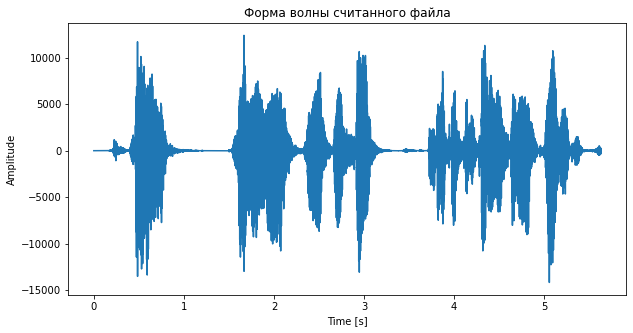

In [5]:
# Форма волны считанного файла
time = np.linspace(0., length, data.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(time, data[:, 0])
plt.title('Форма волны считанного файла')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [6]:
# Попробуем проигрывать исходный файл с разной частотой дискретизации
# Чтобы не менялась длительность исходного сигнала, при уменьшении частоты дискретизации в 2 раза надо соотвествственно 
# уменьшать количество отсчетов, т.е. брать через раз
Audio(data[::2, 0], rate = 24000)

In [7]:
# Частота дискретизации 12 кГц
Audio(data[::4, 0], rate = 12000)

In [8]:
# Частота дискретизации 6 кГц
Audio(data[::8, 0], rate = 6000)

In [9]:
# Частота дискретизации 3 кГц
Audio(data[::16, 0], rate = 3000)

Ответы на вопросы:  
1. В wav-файле хранятся результаты оцифровки аудиосигнала, а именно: квантованные отсчеты значений амплитуды аудиосигнала, взятые с определенной частотой дискретизации. В рассмотренном примере частота дискретизации составляет 48000 Гц, значения амплитуд записаны в знаковом целочисленном формате int16. Параметры дискретизации и квантования можно узнать, прочитав айдиофайл с помощью специальных библиотек (в данном примере было использовано scipy.io.wavfile) и выведя нужную информацию.  
2. При частоте дискретизации ниже 3кГц разобрать речь становится трудно, некоторые звуки становятся неразличимы на слух.  
3. Wav-формат отличается от других тем, что хранит аудиоданные в несжатом виде. Mp3-формат использует сжатие аудиоданных

# Задание 2. Гармонические сигналы (1 балл)

## Теория
[Гармонические колебания](https://ru.wikipedia.org/wiki/Гармонические_колебания) -  колебания, при которых физическая величина изменяется с течением времени по гармоническому (синусоидальному/косинусоидальному) закону. 

В общем случае гармонические колебания задаются формулой:

$$y=A \cos(\omega t+\varphi_0)$$

где $А$ - это амплитуда, $\omega$ – циклическая частота (радиан/с), $\varphi$ - фаза (сдвиг), $t$ – время. 


In [10]:
# Сначала определим функцию для отрисовки сигнала с хорошим масштабом и сеткой
# Это поможет легче анализировать сигнал
def draw_signal(data, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    plt.plot(data, linewidth=2)
    plt.minorticks_on()
    plt.xticks(np.arange(0, 1000, step=100))
    plt.yticks(np.arange((data.min().round())//10*10, 
                         (data.max().round())//10*10+10, step=5))
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()

In [11]:
# Читаем данные с подготовленными сигналами
import pickle
with open("resources/data.pickle", "rb") as f:
    test_data = pickle.load(f)

## Практика

Постройте графики трех сигналов a, b и c из test_data['task2']. Попробуйте подобрать коэффициенты для этих сигналов. Сгенерируйте сигналы (1000 отсчетов) с подобранными коэффициентами. Постройте графики сгенерированных сигналов и пройдите тест на схожесть с оригинальным.


Подсказка. Фаза, период и амплитуда сигнала - целочисленные. Для генерации пользуйтесь библиотекой numpy и функциями arange, sin, cos.

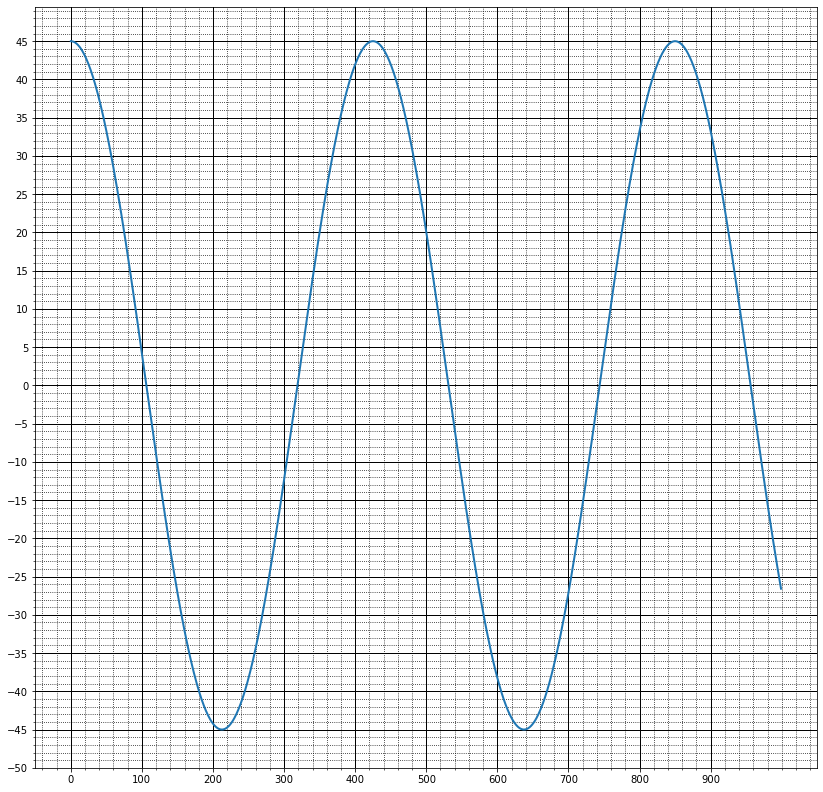

In [12]:
draw_signal(test_data['task2']['a'])

In [13]:
# Создадим точки на оси абсцисс для построения графика
time = np.arange(0, 1000, 1)
# Поберем параметры синусуоды по построенному выше графику. Амплитуда равна 45.
# График имеет максимум при time = 0 => это график косинуса, с нулевой начальной фазой.
# Полный период длится примерно T = 425 отсчетов, поэтому частота будет равна w = 2*pi/T
A, T = 45, 425
w = 2 * np.pi / T
a = A * np.cos(w * time)

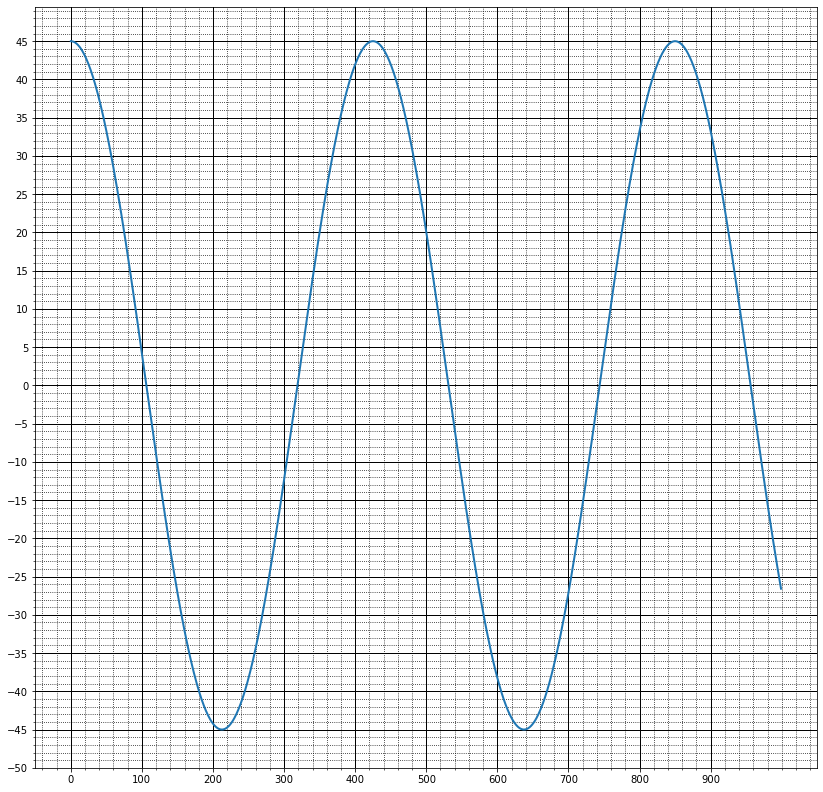

In [14]:
draw_signal(a)

In [15]:
assert len(a) == 1000
assert np.allclose(a, test_data["task2"]["a"], atol=1)
print("Ok!")

Ok!


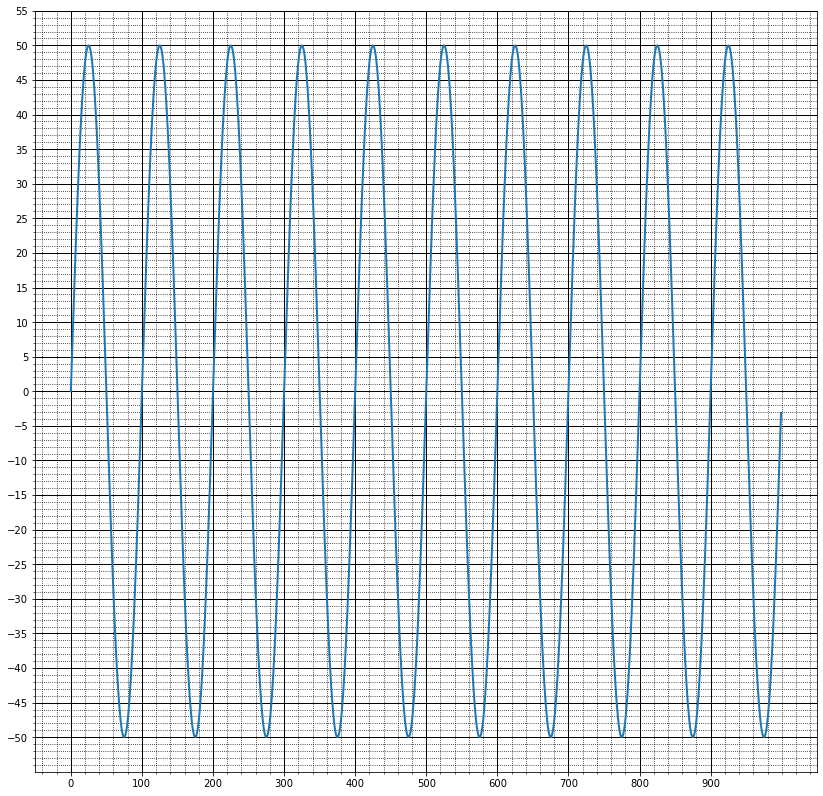

In [16]:
draw_signal(test_data['task2']['b'])

In [17]:
# Амплитуда равна 50. График пересекает начало координат при time = 0 => это график синуса, с нулевой начальной фазой.
# Полный период длится примерно T = 100 отсчетов.
A, T = 50, 100
w = 2 * np.pi / T
b = A * np.sin(w * time)

In [18]:
assert len(b)== 1000
assert np.allclose(b, test_data["task2"]["b"], atol=1)
print("Ok!")

Ok!


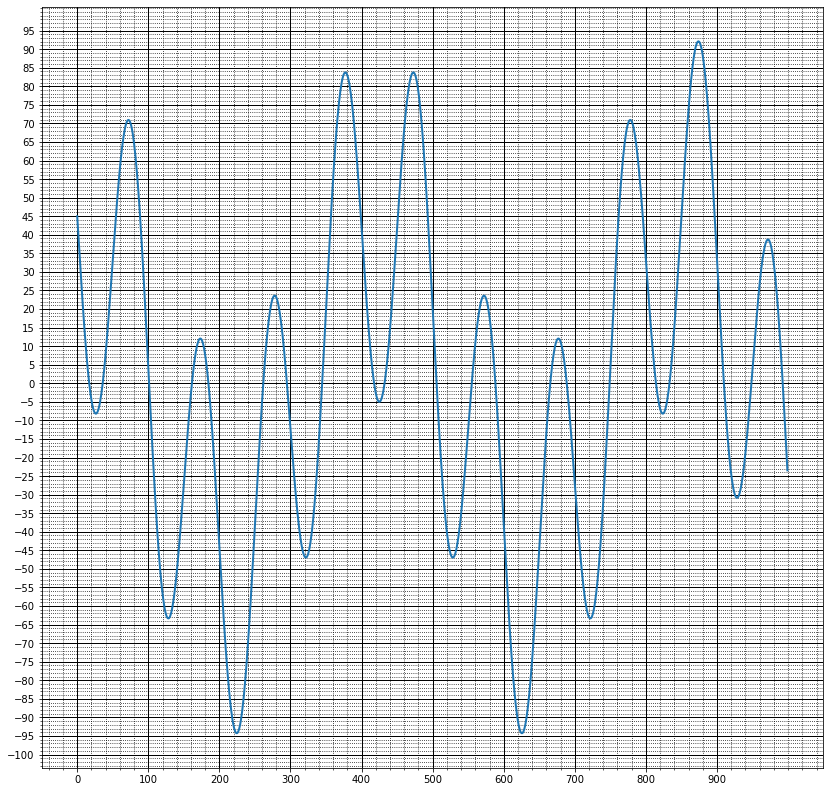

In [19]:
draw_signal(test_data['task2']['c'])

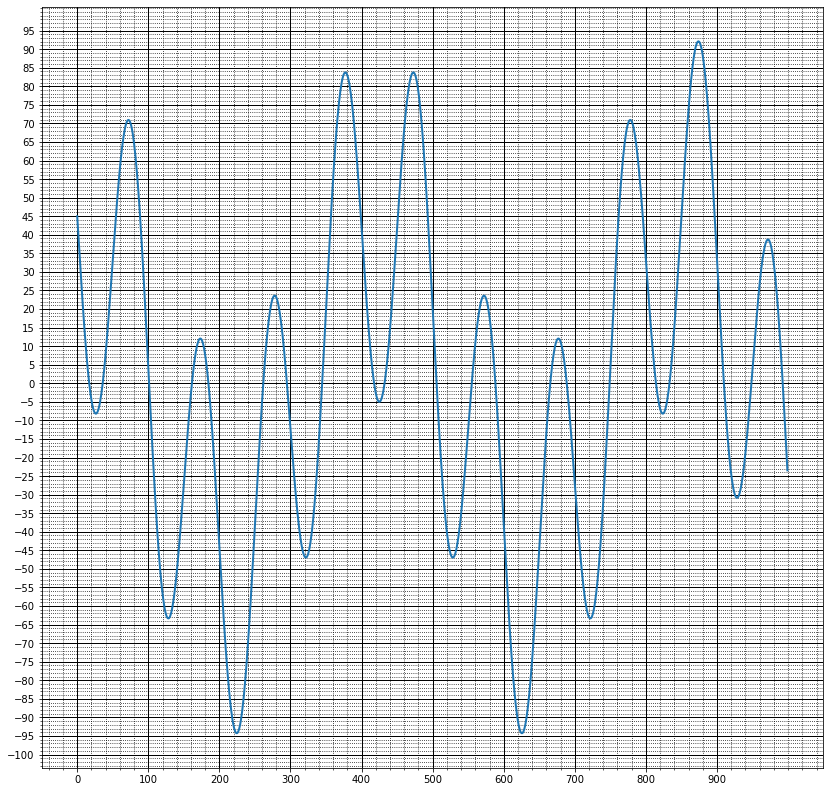

In [20]:
# Сигнал состоит из двух гармоник. По внешнему виду, это похоже на сумму двух вишерассмотренных гармоник.
# Высокочастотная гармоника имеет амплитуду A1, период T1 такие же, как в сигнале "b"
# Низкочастотная гармоника имеет амплитуду A2, период T2 такие же, как в сигнале "a"
A1, T1 = 50, 100
A2, T2 = 45, 425
w1 = 2 * np.pi / T1
w2 = 2 * np.pi / T2
c = -A1 * np.sin(w1 * time) + A2 * np.cos(w2 * time)
draw_signal(c)

In [21]:
assert len(c)== 1000
assert np.allclose(c, test_data["task2"]["c"], atol=1)
print("Ok!")

Ok!


# Задание 3. Свертка (3 балла)

## Теория
Одна из наиболее частых операций, которая выполняется при обработке сигналов, это свёртка. Свёртка имеет много различных применений, например, с ее помощью можно убрать из сигнала шумы или применить к сигналу эффект эхо.


Свёртка — это математическая операция, применённая к двум функциям f и g и порождающая третью функцию. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.  Другими словами, преобразование свёртки однозначно определяет выходной сигнал y(t) для установленного значения входного сигнала x(t) при известном значении функции импульсного отклика системы h(t).

![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution")

Формула свёртки:
$$y_t=\frac{1}{2} \int_0^T x(\tau)h(t-τ)dτ$$
где $\tau$  - длительность импульсной переходной характеристики.

## Практика
Реализуйте операцию свёртки. Сравните её с существующей реализацией scipy.signal.convolve. Постройте графики фильтра, исходного сигнала и результата свертки.

In [22]:
# Функция свертки сигналов во временной области
def convolve(signal, filtr):
    # Реверсируем (отражаем) фильтр
    revers = filtr[::-1]
    # Вспомогательная переменная
    length = len(revers) - 1
    # Добавляем в начало и конец сигнала нулевые значения для последующей корреляции
    padded = np.hstack((np.zeros(length), signal, np.zeros(length)))
    result = []
    # Производим корреляцию дополненного сигнала и отраженного фильтра
    for i in range(len(padded) - length):
        result.append(np.sum(revers * padded[i:i + length + 1]))
    return np.array(result)

In [23]:
def test_convolve(a, b, print_debug=False):
    my_result = convolve(a, b)
    scipy_result = scipy.signal.convolve(a, b, method='direct')
    if print_debug:
        print(f"Your result {my_result}")
        print(f"Scipy result {scipy_result}")
    assert np.allclose(my_result, scipy_result), f"Test {a} conv {b} failed"
    print("Ok!")

In [24]:
a = np.repeat([0,1,0], 10)
b = np.array([0,1,2,3,2,1,0])

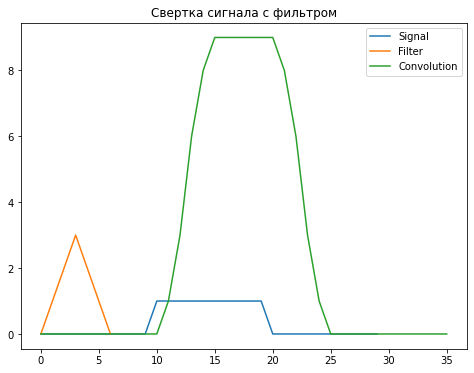

In [25]:
# Нарисуйте результат свертки a и b
plt.figure(figsize = (8, 6))
plt.plot(a, label = 'Signal')
plt.plot(b, label = 'Filter')
plt.plot(convolve(a, b), label = 'Convolution')
plt.title('Свертка сигнала с фильтром')
plt.legend()
plt.show()

In [26]:
test_convolve(a, b, print_debug=False)

Ok!


## Задание 4. * Алгоритм Карплуса-Стронга 

Реализуйте  [Алгоритм Карплуса-Стронга](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis). В качестве фильтра используйте усреднитель двух смежных отсчетов. Проверьте результат. 

Отрисуйте и воспроизведите полученный сигнал. На что влияют параметры генерации? Попробуйте имитировать звучание разных струн гитары.

In [27]:
# Функция, генерирующая звук гитарной струны по алгоритму Карплуса-Стронга
def karplus_strong(noise, N):
    # Noise - input, N - number of samples to generate
    noise_len = len(noise)
    # Создаем результирующий массив длиной N
    y = np.zeros(N)
    # Первые noise_len элементов заполняем шумом
    y[:noise_len] = noise
    # Первый (после шума) элемент будет равен половине первого элемента шума 
    y[noise_len] = y[0] / 2
    # Начиная с индекса noise_len + 1, заполняем массив полусуммами значений с задержкой noise_len
    for i in range(noise_len + 1, N):
        y[i] = (y[i - noise_len - 1] + y[i - noise_len]) / 2
    return y    

In [28]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 82.41
sec = 2
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate/frequency))) # [-1, 1]

gen_wav = karplus_strong(noise, gen_len)
assert np.allclose(gen_wav[:len(noise)], noise), "Generated signal must starting with noise"
assert np.allclose(gen_wav[len(noise)], (noise[0])/2), "Out of range samples eq 0."
assert np.allclose(gen_wav[len(noise)+1: 2*len(noise)], (noise[:-1] + noise[1:])/2), \
    "Bad requrent rule( 1 iteration)"
assert np.allclose(gen_wav[2*len(noise)], (noise[0]/2 + noise[-1])/2), \
    "Bad requrent rule( 2 iteration)"
assert np.allclose(gen_wav[2*len(noise)+2: 3*len(noise)], \
                   (((noise[:-1] + noise[1:])/2)[:-1] + ((noise[:-1] + noise[1:])/2)[1:])/2), \
    "Bad requrent rule( 3 iteration)"
print('All Ok!')

All Ok!


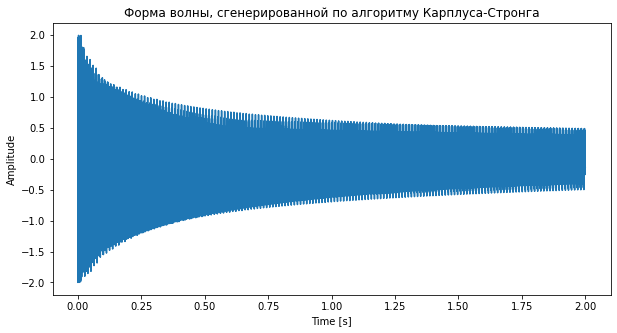

In [29]:
# Нарисуем график сгенерированной волны
time = np.linspace(0., sec, gen_len)
plt.figure(figsize=(10, 5))
plt.plot(time, gen_wav)
plt.title('Форма волны, сгенерированной по алгоритму Карплуса-Стронга')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [30]:
Audio(gen_wav, rate = sample_rate)

In [31]:
# Повысим частоту генерируемого сигнала, что при прочих равных условиях означает уменьшение размера массива noise
np.random.seed(seed=1)
frequency = 180
sec = 2
gen_len = sample_rate * sec
noise = np.random.uniform(-1, 1, int(sample_rate/frequency))

Audio(karplus_strong(noise, gen_len), rate = sample_rate)

In [32]:
# Изменим способ генерации случайного шума. Вместо равномерного используем нормальный шум
np.random.seed(seed=1)
frequency = 180
sec = 2
gen_len = sample_rate * sec
noise = np.random.randn(int(sample_rate/frequency))

Audio(karplus_strong(noise, gen_len), rate = sample_rate)

В текущей реализации алгоритма Карплуса-Стронга гиперпараметром, влияющим на характеристики звука, является массив шума. Чем больше размер массива шума, тем ниже основной генерируемый тон. Также небольшое влияние оказывает характер шума: при равномерном шуме сигнал получается более резким по сравнению с нормальным шумом.